<h1>PRML Project Assignment ALT- Celebrity BMI</h1>

<h2>
TEAM MEMBERS:
</h2>

Kathiravan S      (CS22B2052) \
Avinaash A        (CS22B1064) \
Ashwinth Anbu     (CS22B2055) 

In [1]:
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import os
import pandas as pd
import numpy as np
from torchvision import transforms
from tqdm import tqdm
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from skimage import io 
warnings.filterwarnings('ignore')

<h2>Setting Basic Parameters</h2>

In [2]:
BASE_PATH = "/media/kathir/Apps and Games/prml project/sample_faces"
CSV_PATH = "/media/kathir/Apps and Games/prml project/actlabel.csv"
OUTPUT_FILE = "face_features.csv"

<h2>Feature Extraction - FaceNet Features (512 x 2 = 1024 Features per Person)</h2>

In [3]:
def load_and_process_image(image_path, device, mtcnn, resnet):
    from PIL import Image
    try:
        img = Image.open(image_path).convert('RGB')
        face = mtcnn(img)
        if face is not None:
            face = face.unsqueeze(0).to(device)
            features = resnet(face).detach().cpu().numpy().flatten()
            return features
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
    return None

In [4]:
def extract_features(base_path, csv_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    mtcnn = MTCNN(device=device)
    resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
    
    # Load the CSV file
    df = pd.read_csv(csv_path)
    if 'UID' not in df.columns:
        raise ValueError("The CSV file must contain a 'uid' column.")
    
    uids = df['UID'].unique()

    front_path = os.path.join(base_path, 'front')
    all_features = []
    processed_uids = []

    for uid in tqdm(uids, desc="Processing images"):
        # Find the first image corresponding to this UID
        image_pattern = f"{uid}"
        matching_images = [
            fname for fname in os.listdir(front_path)
            if fname.startswith(image_pattern) and fname[len(image_pattern)].isdigit()
        ]

        if not matching_images:
            print(f"Warning: No images found for UID {uid}.")
            continue

        selected_image = os.path.join(front_path, matching_images[0])

        # Extract features
        front_features = load_and_process_image(selected_image, device, mtcnn, resnet)

        if front_features is not None:
            all_features.append(front_features)
            processed_uids.append(uid)

    # Create feature column names
    front_cols = [f'front_feature_{i}' for i in range(512)]  # FaceNet outputs 512-D vectors

    df_features = pd.DataFrame(all_features, columns=front_cols)
    df_features.insert(0, 'UID', processed_uids)

    return df_features



<h2>Extracting...</h2>

In [5]:
print("Starting feature extraction...")
features_df = extract_features(BASE_PATH, CSV_PATH)

Starting feature extraction...
Using device: cuda


Processing images: 100%|████████████████████████| 50/50 [00:02<00:00, 24.08it/s]


In [6]:
features_df.to_csv(OUTPUT_FILE, index=False)
print(f"Features saved to {OUTPUT_FILE}")
print(f"Processed {len(features_df)} persons successfully")

Features saved to face_features.csv
Processed 50 persons successfully


<h2>Initializing Training and Testing Parameters</h2>

In [7]:
persons = pd.read_csv("/media/kathir/Apps and Games/prml project/actlabel.csv")
features = pd.read_csv("face_features.csv")
filtered_df = pd.merge(features, persons, on='UID')
filtered_df['bmi'] = (filtered_df['weight'])/(filtered_df['height']**2)
xs = np.array(filtered_df.iloc[:, 2:512])
xs_train = xs[:int(0.8*len(xs))]
xs_test = xs[int(0.8*len(xs)):]
filtered_df['bmi'].fillna((filtered_df['bmi'].mean()), inplace=True)
ys = np.array(filtered_df['bmi'])
print(len(xs), len(ys))
ys_train = ys[:int(0.8*len(ys))]
ys_test = ys[int(0.8*len(ys)):]

50 50


In [8]:
persons

,id,UID,name,height,weight
0,1,akshay,akshay kumar,1.78,80
1,2,ja,john abraham,1.82,94
2,3,varun,varun dhawan,1.68,78
3,4,tiger,Tiger shroff,1.75,72
4,5,salman,Salman khan,1.74,75
5,6,srk,Shahrukh khan,1.73,75
6,7,ayushman,ayushman khurana,1.68,72
7,8,vikky,vicky kaushal,1.83,80
8,9,rajkumar,rajkumar rao,1.70,72
9,10,nawaz,nawazuddin,1.68,60


In [9]:
len(xs_train),len(ys_train)

(40, 40)

<h2>Loading Team Member Face Images</h2>

<h2>Diagnostic Functions</h2>

In [10]:
def diagnostics():
    plt.figure(figsize=(10, 6))
    
    # Plotting Actual vs Predicted
    plt.subplot(1, 2, 1)
    plt.scatter(ys, predictions, color='teal', alpha=0.6)
    plt.plot([min(ys), max(ys)], [min(ys), max(ys)], color='red', linestyle='--', linewidth=2) 
    plt.title('Actual vs Predicted BMI')
    plt.xlabel('Actual BMI')
    plt.ylabel('Predicted BMI')
    
    # Residuals plot (Actual - Predicted)
    residuals = ys - predictions
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=predictions, y=residuals, color='red', alpha=1)
    plt.axhline(0, color='black', linestyle='--', linewidth=2)  # Horizontal line at 0
    plt.title('Residuals vs Predicted BMI')
    plt.xlabel('Predicted BMI')
    plt.ylabel('Residuals')
    
    plt.tight_layout()
    plt.show()

<h2>Linear Regression</h2>

In [11]:
#Linear Regression  -- Inbuilt

lr_model = LinearRegression()
lr_model.fit(xs_train, ys_train)
predictions = lr_model.predict(xs)

Root Mean Squared Error (RMSE): 1.7324969139257853
Mean Absolute Error (MAE): 0.6712591691385856
R^2 Score: 0.35978855066765125
Pearson Correlation Coefficient: 0.7488490041334255


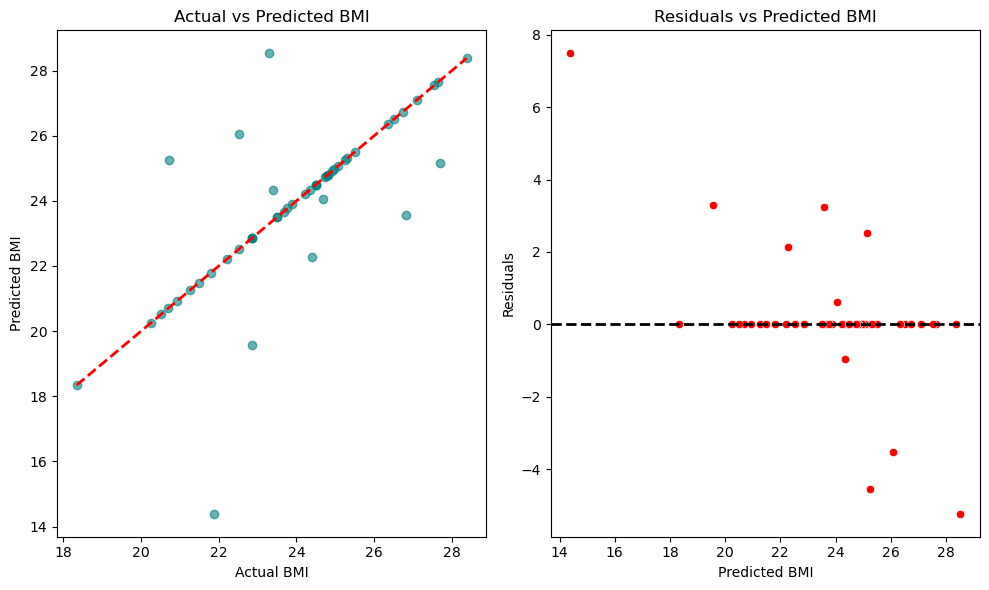

In [12]:
mse = mean_squared_error(ys, predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
mae = mean_absolute_error(ys, predictions)
print("Mean Absolute Error (MAE):", mae)
r2 = r2_score(ys, predictions)
print("R^2 Score:", r2)
pearson_corr, _ = pearsonr(ys, predictions)
print("Pearson Correlation Coefficient:", pearson_corr)
diagnostics()

<h2>Random Forest Regression</h2>

In [13]:
#Random Forest
rf_model = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)
rf_model.fit(xs_train, ys_train)
predictions = rf_model.predict(xs)

Root Mean Squared Error (RMSE): 1.2215687299199498
Mean Absolute Error (MAE): 0.9028587589782698
R^2 Score: 0.6817163635758352
Pearson Correlation Coefficient: 0.8629405223387963


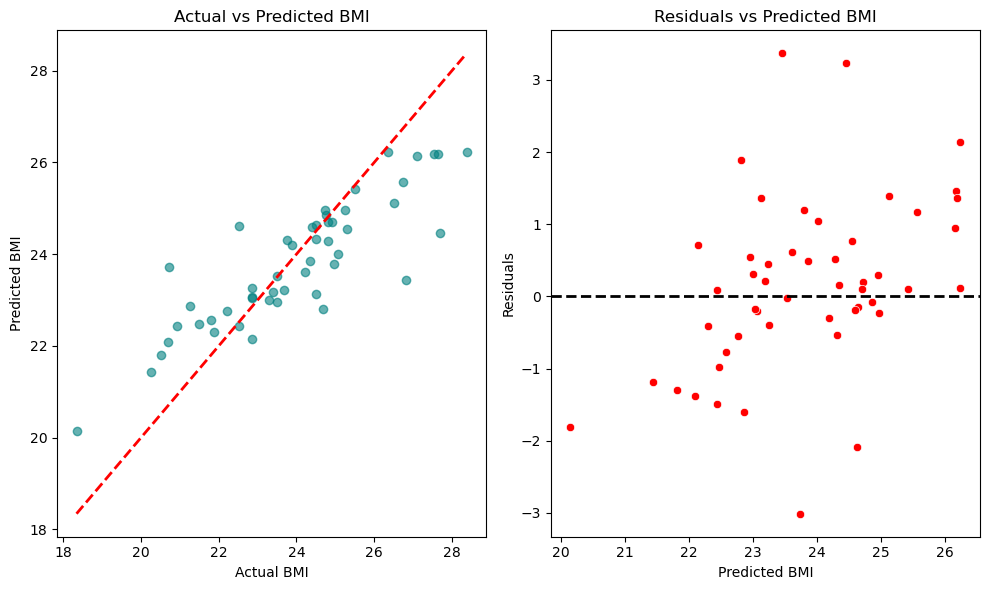

In [14]:
mse = mean_squared_error(ys, predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
mae = mean_absolute_error(ys, predictions)
print("Mean Absolute Error (MAE):", mae)
r2 = r2_score(ys, predictions)
print("R^2 Score:", r2)
pearson_corr, _ = pearsonr(ys, predictions)
print("Pearson Correlation Coefficient:", pearson_corr)
diagnostics()

<h2>XG Boost Regression</h2>

In [15]:
xgb_model = XGBRegressor(
    n_estimators=1000,    
    max_depth=6,         
    learning_rate=0.1,   
    subsample=0.8,      
    random_state=42
)
xgb_model.fit(xs_train, ys_train)
predictions = xgb_model.predict(xs)

Root Mean Squared Error (RMSE): 1.0079858004131879
Mean Absolute Error (MAE): 0.342795143997562
R^2 Score: 0.7832858216027766
Pearson Correlation Coefficient: 0.8858742701357359


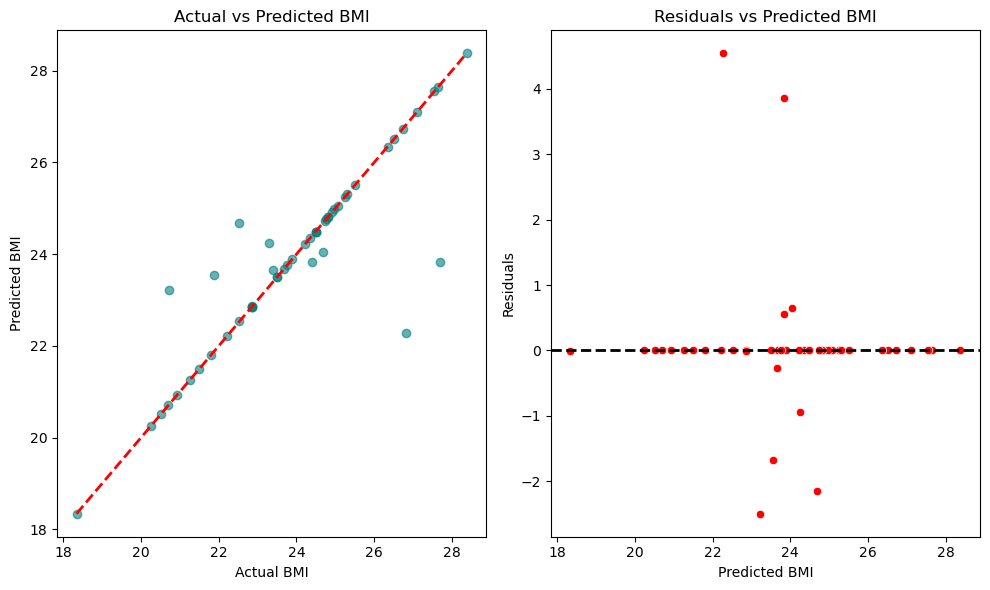

In [16]:
mse = mean_squared_error(ys, predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
mae = mean_absolute_error(ys, predictions)
print("Mean Absolute Error (MAE):", mae)
r2 = r2_score(ys, predictions)
print("R^2 Score:", r2)
pearson_corr, _ = pearsonr(ys, predictions)
print("Pearson Correlation Coefficient:", pearson_corr)
diagnostics()

<h1>Final XG-Boost Results</h1>

<h2>R^2 :: 0.78</h2>
<h2>Pearson Correlation :: 0.88</h2>
<h2>MSE :: 1.00</h2>
<h2>MAE :: 0.34</h2>